# **0 Environment setup**

## **0.1 Global constants**

In [ ]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/bd_project/datasets"
GDRIVE_TRAIN_DATASET_FILE = GDRIVE_DATA_DIR + "/training_v2.csv"
GDRIVE_DICTIONARY_DATASET_FILE = GDRIVE_DATA_DIR + "/WiDS Datathon 2020 Dictionary.csv"
GDRIVE_UNLABELED_DATASET_FILE = GDRIVE_DATA_DIR + "/unlabeled.csv"
GDRIVE_SPLIT_TRAIN = GDRIVE_DATA_DIR + '/train_df.csv'
GDRIVE_SPLIT_TEST = GDRIVE_DATA_DIR + '/test_df.csv'
GDRIVE_FOR_GRID = GDRIVE_DATA_DIR + '/for_grid.csv'

RANDOM_SEED = 42 # for reproducibility

## **0.2 Spark + Google Colab setup**

### **0.2.1 Install PySpark and related dependencies**

In [ ]:
!pip install pyspark==2.4.5
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     |████████████████████████████████| 217.8MB 62kB/s 
     |████████████████████████████████| 204kB 40.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=f6ab887307aab493cb40cc4b0315d6a49de0476441b2a1213fa7f22400cf00bd
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 43 not upgraded.
Need to get 35.8 MB of archives.
After this 

## **0.2.2 Import useful Python packages**

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
del globals()['abs']
from pyspark import SparkContext, SparkConf

from typing import Dict, Tuple, Sequence

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **0.2.3 Create Spark context**

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '20G').set('spark.driver.maxResultSize', '10G')

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **0.2.4 Create <code>ngrok</code> tunnel to check the Spark UI**

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-06-18 12:30:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.214.118.253, 52.201.33.182, 34.227.164.168, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.214.118.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  70.5MB/s    in 0.2s    

2020-06-18 12:30:40 (70.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://937c448ad294.ngrok.io


## **0.2.5 Link Colab to our Google Drive**

In [ ]:
# Point Colaboratory to our Google Drive

from google.colab import drive

drive.mount(GDRIVE_DIR, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## **0.2.6 Check everything is ok**

In [ ]:
spark

In [ ]:
sc._conf.getAll()

[('spark.driver.memory', '20G'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1592483439393'),
 ('spark.driver.port', '41931'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.ui.port', '4050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memory', '4G'),
 ('spark.driver.host', 'a0234021d7c8'),
 ('spark.ui.showConsoleProgress', 'true')]

# **1 Data collection**

## **1.1 Read dataset file into a Spark Dataframe**

In [ ]:
df = spark.read.load(GDRIVE_TRAIN_DATASET_FILE, 
                     format="csv", 
                     sep=",", 
                     inferSchema=True, 
                     header=True
                     )

dictionary_pdf = pd.read_csv(GDRIVE_DICTIONARY_DATASET_FILE)

NUMERIC = list(dictionary_pdf.loc[dictionary_pdf['Data Type'] == 'numeric']['Variable Name'])
NUMERIC.remove('pred')
NUMERIC.append('bmi')

STRING = list(dictionary_pdf.loc[dictionary_pdf['Data Type'] == 'string']['Variable Name'])
for feature in ['bmi', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'icu_admit_type']:
  STRING.remove(feature)

INTEGER = list(dictionary_pdf.loc[dictionary_pdf['Data Type'].isin(['binary', 'integer'])]['Variable Name'])
INTEGER.append('apache_2_diagnosis')
INTEGER.append('apache_3j_diagnosis')

for c in NUMERIC:
    df = df.withColumn(c, df[c].cast("float"))
for c in INTEGER:
    df = df.withColumn(c, df[c].cast("int"))

import pyspark.sql.functions as F
cols = [F.when(~F.col(x).isin("NA"), F.col(x)).alias(x)  for x in df.columns]
df = df.select(*cols)

# **2 Data exploration**

## **2.1 Check the shape of the loaded dataset, i.e., number of rows and columns**

In [ ]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(df.count(), len(df.columns)))

The shape of the dataset is 91713 rows by 186 columns


## **2.2 Print out the schema of the loaded dataset**

In [ ]:
df.printSchema()

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- hospital_death: integer (nullable = true)
 |-- age: float (nullable = true)
 |-- bmi: float (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: float (nullable = true)
 |-- hospital_admit_source: string (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: float (nullable = true)
 |-- readmission_status: integer (nullable = true)
 |-- weight: float (nullable = true)
 |-- albumin_apache: float (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: integer (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: inte

## **2.3 Display the first 5 rows of the dataset**

In [ ]:
df.show(5)

+------------+----------+-----------+--------------+----+-----+----------------+---------+------+------+---------------------+--------------------+------+-------------+------------+----------------+------------------+------+--------------+------------------+-------------------+---------------------+----------+----------------+----------+-----------------+-----------+---------------+----------------+-----------------+-----------------+--------------+-----------------+-----------------+----------------+----------+------------+-------------------+-----------+---------+---------------+-------------+-----------+------------------+-----------------+----------+----------------------+----------------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+-------------------+-------------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+--------------

## **2.4 Let's define the numerical and categorical features and the target variable**

In [ ]:
# To collect numerical and categorical features, I used the `WiDS Datathlon 2020 Dictionary.csv` file;
# This file contains all the information about every feature in the dataset.
# Unfortunately, some information is wrong (e.g., `bmi`'s data type is considered to be string,
# while it is obviously numeric.
# For this reason, I analyzed by hand the dictionary file and I moved the features in their correct place.

INDEX_FEATURE = 'encounter_id'
NUMERICAL_FEATURES = list(dictionary_pdf.loc[dictionary_pdf['Data Type'] == 'numeric']['Variable Name'])
NUMERICAL_FEATURES.remove('pred')
NUMERICAL_FEATURES.append('bmi')
CATEGORICAL_FEATURES = list(dictionary_pdf.loc[dictionary_pdf['Data Type'].isin(['integer', 'binary', 'string'])]['Variable Name'])
for feature in ['encounter_id', 'hospital_id', 'patient_id', 'bmi', 'hospital_death', 'icu_admit_type']:
    CATEGORICAL_FEATURES.remove(feature)
TARGET_VARIABLE = 'hospital_death'

In [ ]:
print("There are {} numerical features, {} categorical features and 1 target variable.".format(len(NUMERICAL_FEATURES), len(CATEGORICAL_FEATURES), len(INDEX_FEATURE)))

There are 153 numerical features, 29 categorical features and 1 target variable.


## **2.5 Summary of Descriptive Statistics**

In [ ]:
df.describe().toPandas().transpose() # Transpose will allow a better visualization

0  ...                    4
summary                      count  ...                  max
encounter_id                 91713  ...               131051
patient_id                   91713  ...               131051
hospital_id                  91713  ...                  204
hospital_death               91713  ...                    1
...                            ...  ...                  ...
leukemia                     90998  ...                    1
lymphoma                     90998  ...                    1
solid_tumor_with_metastasis  90998  ...                    1
apache_3j_bodysystem         90051  ...               Trauma
apache_2_bodysystem          90051  ...  Undefined diagnoses

[187 rows x 5 columns]

## **2.6 Check for any missing values**

In [ ]:
# First, let's create a dictionary containing all the columns as keys and the number of missing values appearing in each column as values

def missing_features(df):
    """
    Searches for the missing values of a dataframe.

    Parameters
    ----------
    df : PySpark dataframe

    Returns
    -------
    Dict
        Dictionary containing all the columns of the dataframe df as keys and the number of missing values for each of the keys as values
    """
    missing_dict = {i : 0 for i in df.schema.names}
    for feature in missing_dict:
        missing_dict[feature] = df.where(col(feature).isNull()).count()
    return missing_dict

In [ ]:
missing_dict = missing_features(df)

In [ ]:
# Let's analyze it by printing the name of each column and its respective number.

for key, value in missing_dict.items():
    print("N. of missing values of column `{:s}` = {:d}".format(key, value))

N. of missing values of column `encounter_id` = 0
N. of missing values of column `patient_id` = 0
N. of missing values of column `hospital_id` = 0
N. of missing values of column `hospital_death` = 0
N. of missing values of column `age` = 4228
N. of missing values of column `bmi` = 3429
N. of missing values of column `elective_surgery` = 0
N. of missing values of column `ethnicity` = 1395
N. of missing values of column `gender` = 25
N. of missing values of column `height` = 1334
N. of missing values of column `hospital_admit_source` = 21409
N. of missing values of column `icu_admit_source` = 112
N. of missing values of column `icu_id` = 0
N. of missing values of column `icu_stay_type` = 0
N. of missing values of column `icu_type` = 0
N. of missing values of column `pre_icu_los_days` = 0
N. of missing values of column `readmission_status` = 0
N. of missing values of column `weight` = 2720
N. of missing values of column `albumin_apache` = 54379
N. of missing values of column `apache_2_dia

In [ ]:
# It's easy to see that some columns have too many missing values to make any contribution.
# To get an even better idea of this, let's compute the dictionary containing each value and
# the percentage of values that are missing.

df_count = df.count()
missing_dict_perc = {key : value/df_count for key, value in missing_dict.items()}

In [ ]:
def missing_above_percentage(missing_dict_perc, percentage_1, percentage_2):
    """
    Searches for the columns with a percentage of missing values in an interval.

    Parameters
    ----------
    missing_dict_perc : Dict
    percentage_1 : int
    percentage_2 : int

    Returns
    -------
    Dict
        Dictionary containing the columns of the dataframe with missing values percentage in the interval [percentage_1, percentage_2] as keys and their respective missing percentage as values
    """
    return {key : value for key, value in missing_dict_perc.items() if value > percentage_1 and value <= percentage_2}

In [ ]:
# Let's split the features in two groups: the one missing more than 80% of the data and the ones missing less than 80%.

missing_80 = missing_above_percentage(missing_dict_perc, 0.80, 1)
missing_0_80 = missing_above_percentage(missing_dict_perc, 0, 0.80)

total_missing = missing_above_percentage(missing_dict_perc, 0, 100)

print("There are exactly:")
print("- " + str(len(missing_80)) + " columns missing x > 80% of the data;")
print("- " + str(len(missing_0_80)) + " columns missing x <= 80% of the data;")
print("for a total of " + str(len(total_missing)) + " columns missing at least some data and " + str(len(df.columns) - len(total_missing)) + " full columns.")

There are exactly:
- 34 columns missing x > 80% of the data;
- 141 columns missing x <= 80% of the data;
for a total of 175 columns missing at least some data and 11 full columns.


### **2.6.1 Observations**

As we can see, the vast majority of features is missing some data (175 columns out of 186).
There are different ways to address this kind of problem:
1. **Removal of the column**: remove the entire column in which null values appear.
2. **Mean/median/mode imputation**: calculate the mean/median/mode of the non-missing values for each column and replace the missing values with it.
3. **Prediction of the value**: use simple prediction algorithms to predict the best value for the missing values.


## **2.7 Correlation between features**
In this section, I'm going to plot the correlation matrix heatmap first and I'm going to try to get something out of it. It's not going to be easy to discern some information from it since the features space is really big, thus I'm also going to analyze it mathematically.

In [ ]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
pdf = df.toPandas()

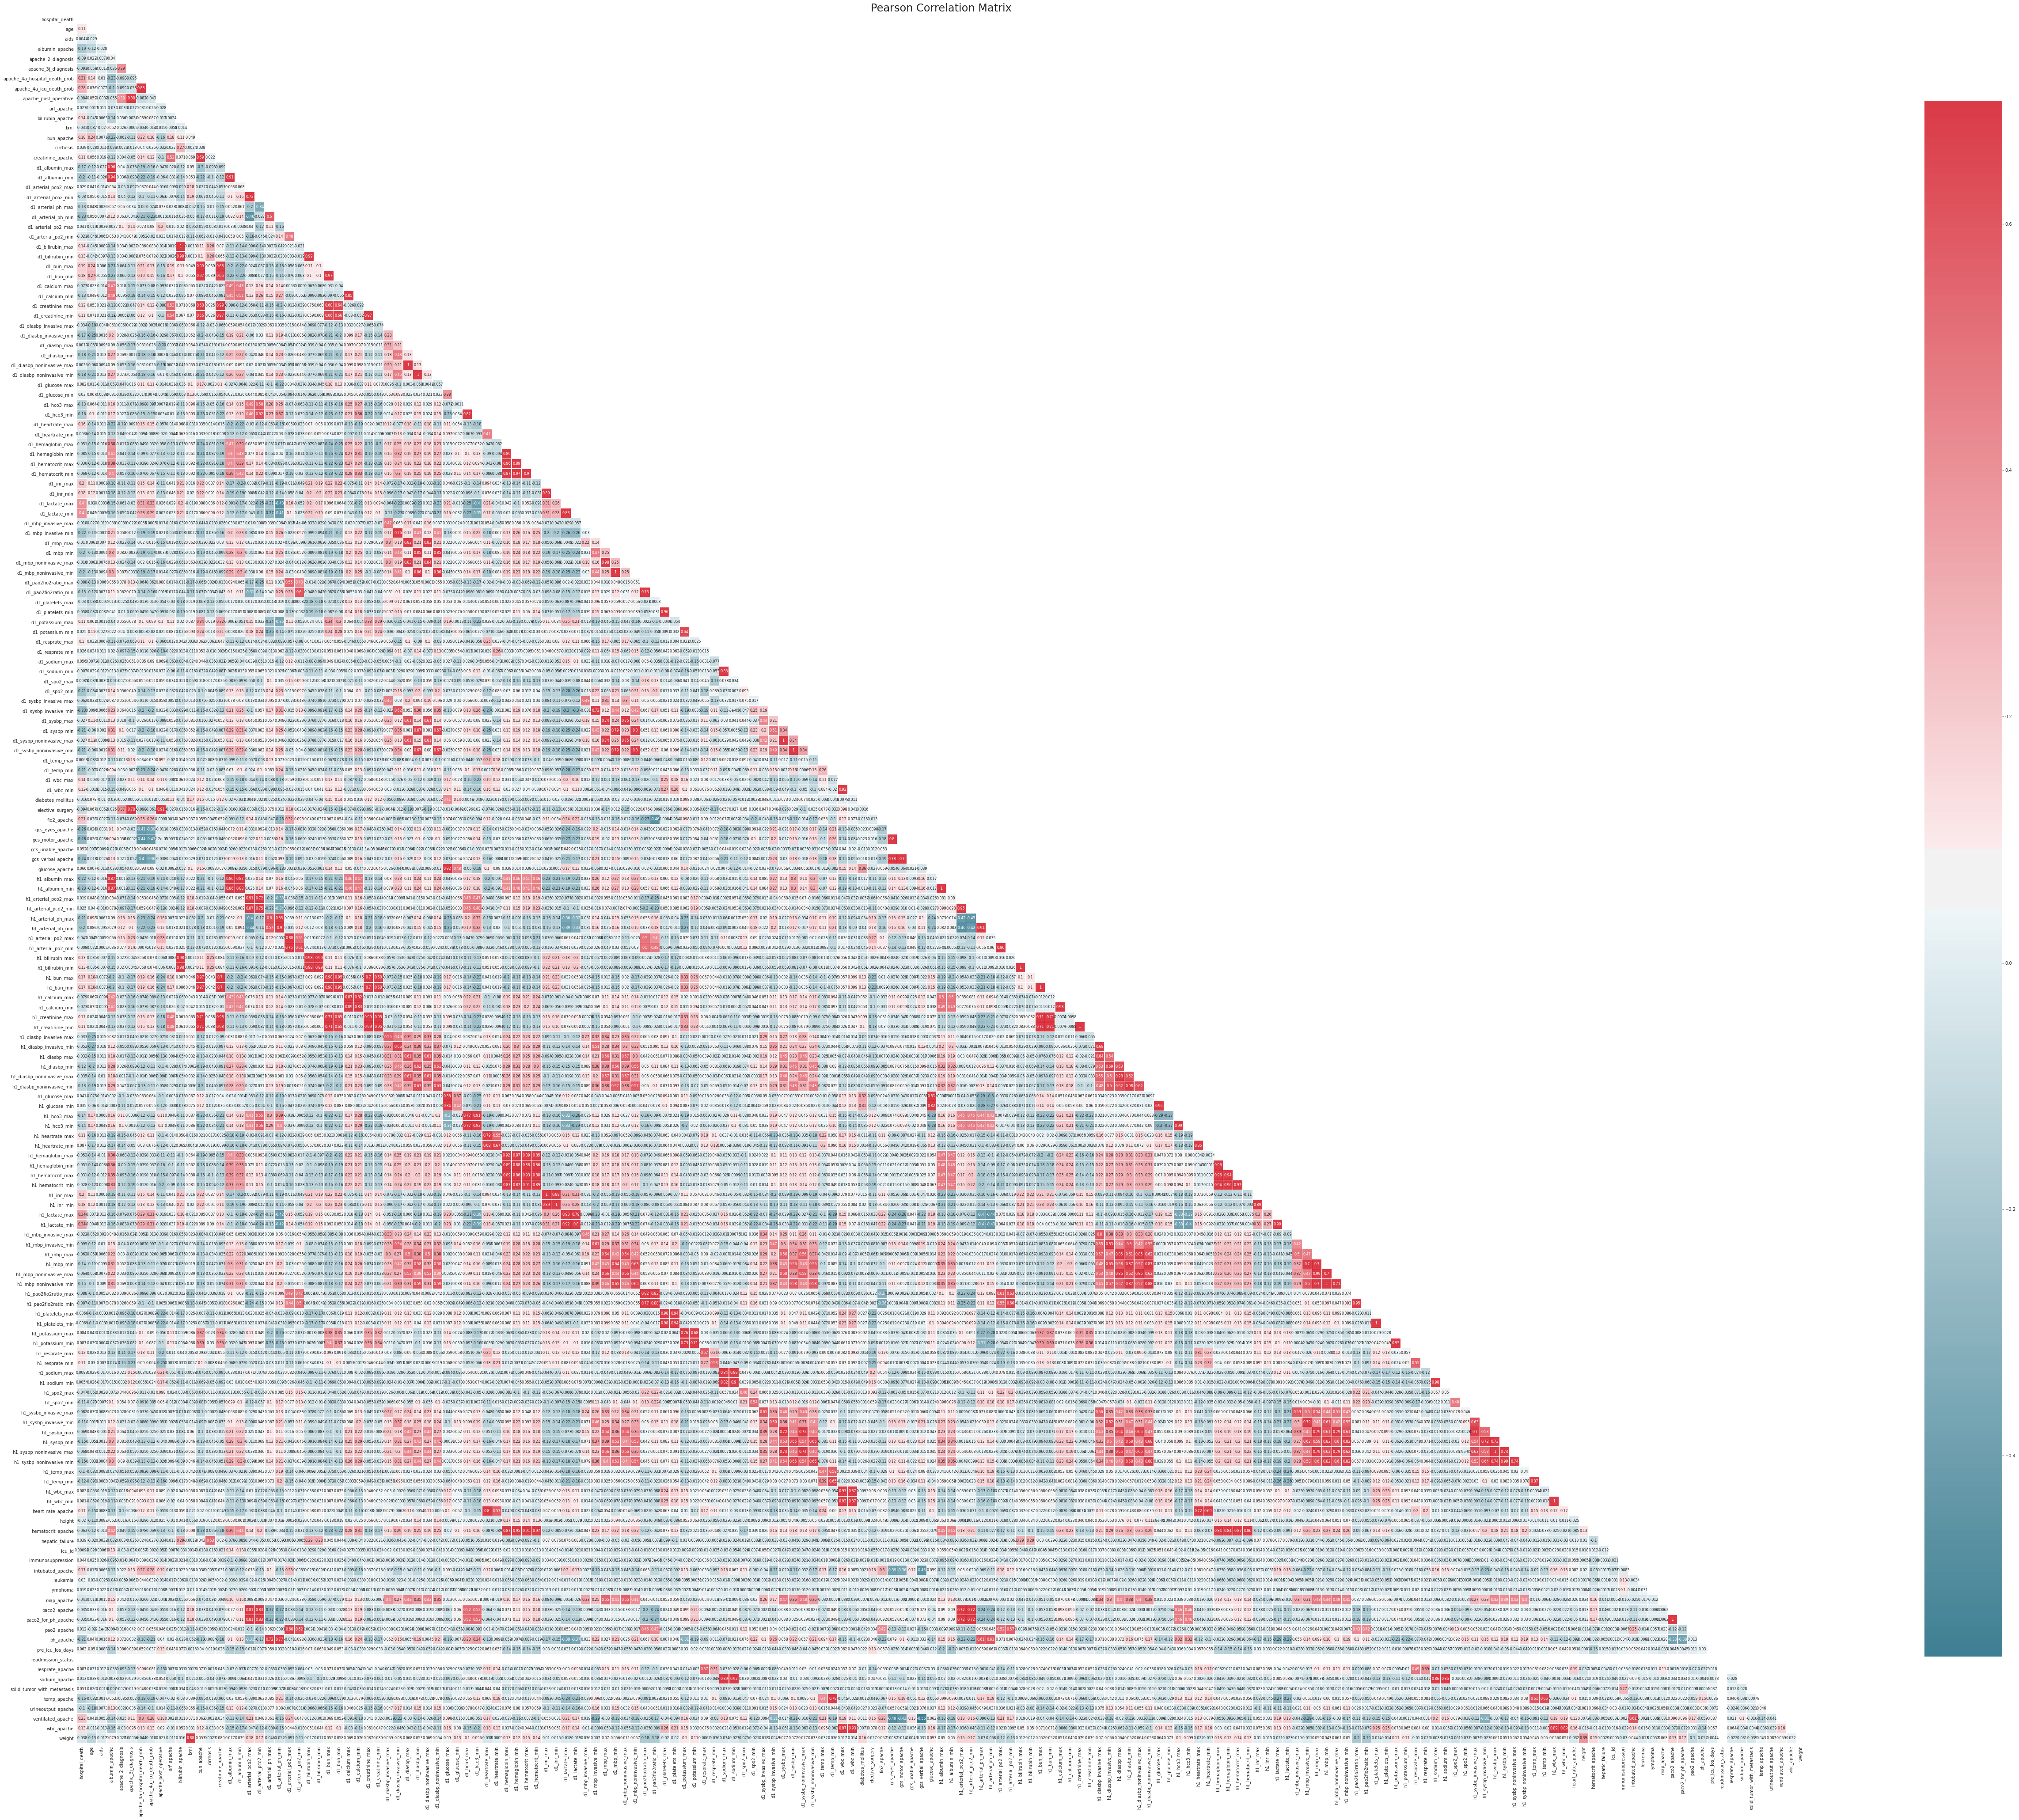

In [ ]:
# Select the features we want to use to compute the correlation matrix (i.e., everything except the id features)
features = [TARGET_VARIABLE] + sorted(NUMERICAL_FEATURES + CATEGORICAL_FEATURES)

mask = np.zeros_like(pdf[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(96, 72))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(pdf[features].corr(), 
              linewidths=0.25, 
              vmax=0.7, 
              square=True,
              ax=ax, 
              cmap=cmap, 
              linecolor='w', 
              annot=True, 
              annot_kws={"size":8}, 
              mask=mask, 
              cbar_kws={"shrink": .9});

In [ ]:
# Create the correlation matrix
corr_matrix = pdf[features].corr()

# The correlation matrix is symmetrical => we can select its upper part
# We can also ignore the main diagonal, since row and col would be the same, thus correlation would always be equal to 1
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [ ]:
# Find features with correlation greater than 0.95

def high_correlated_features(corr_matrix, threshold):
    """
    Searches for the high correlated features in the correlation matrix of a dataframe.

    Parameters
    ----------
    corr_matrix : Pandas dataframe
    threshold : float

    Returns
    -------
    set
        Set of features with correlation factor greater or equal than the threshold
    """
    correlated_features = set()
    for row in corr_matrix.index:
        for col in corr_matrix.columns:
            if abs(corr_matrix.loc[row, col]) >= threshold and col not in correlated_features:
                correlated_features.add(row)
    return correlated_features

len(high_correlated_features(upper, 0.95))

44

### **2.7.1 Observations**
As we can see, there are actually 44 features which have a really strong correlation (> 0.95). This gives us the impression that some information is redundant and we can probably apply some dimensionality reduction to our data.

Nevertheless, we're not going to perform any operation on the whole dataset; the information we're getting are just useful to get an initial overview of the data. In fact, we first want to split the dataset in training and testing, such that we can work on just the training, avoiding incorrect evaluations in the future.

## **2.8 Correlation between the features and the target variable `hospital_death`**

In [ ]:
i = 0
for row in corr_matrix.index:
    if row == TARGET_VARIABLE:
        continue
    if abs(corr_matrix.loc[row, TARGET_VARIABLE]) < 0.05:
        i += 1

print("There are {} features with low correlation (i.e. < 0.05) with the target variable `{}`.".format(i, TARGET_VARIABLE))

There are 54 features with low correlation (i.e. < 0.05) with the target variable `hospital_death`.


### **2.8.1 Observations**
Not only features are really correlated, there are also a lot of features with very low correlation with the target variable. This means that we probably need to apply some **dimensionality reduction**.

## **2.9 Class distribution**
Before diving into the learning pipeline, I'm going to observe one last thing: class distribution of the target variable.

As we are going to see in the following cells, there is a severe skew in the class distribution.

In [ ]:
df.groupBy(TARGET_VARIABLE).count().show()
print(" - percentage of hospital deaths (target variable == 1) = {}%".format(np.round(100*df.where(col('hospital_death') == '1').count()/df.count(), 2)))
print(" - percentage of hospital survivals (target variable == 0) = {}%".format(np.round(100*df.where(col('hospital_death') == '0').count()/df.count(), 2)))

+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1| 7915|
|             0|83798|
+--------------+-----+

 - percentage of hospital deaths (target variable == 1) = 8.63%
 - percentage of hospital survivals (target variable == 0) = 91.37%


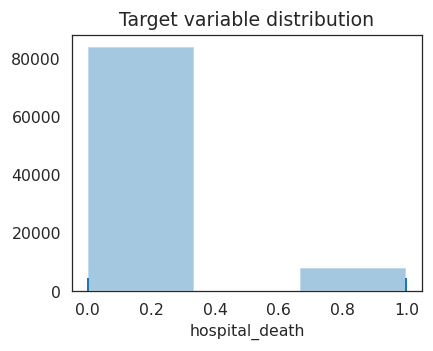

In [ ]:
with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(4, 3), dpi=113)
  plt.title('Target variable distribution')

  _ = sns.distplot(pdf['hospital_death'], bins=3, kde=False, rug=True)

### **2.9.1 Observations**
Having an unbalanced dataset means that we are probably going to face some problems.
1. First, we have to be very careful during the **splitting phase**. In fact, having very few examples in one of the classes means that we could end up having almost zero cases of the minority class in the testing set, invalidating completely the evaluation part.
2. There is also a problem during the **learning part** itself, since the class imbalance could lead our model to be very biased and it could potentially ignore the minority class in the training part.

How can we solve these two problems?

Well, the first one is easily solved using **stratified random sampling**, which preserves the same proportions of the starting dataset after the splitting.

For the second problem, one solution is to **sample the dataset**, with either undersampling or oversampling.

# **3 The Learning Pipeline**
In this section, we're going to cover the training part itself.

Before we get started, we need to solve each and every problem we brought up in the data exploration part. To summarize:

1. How can we split the dataset without losing the proportions?
2. How can we handle missing data?
3. How can we handle correlated features?
4. How can we handle the skew in class distribution?

## **3.1 Splitting the dataframe**
First thing first, we obviously need to split the dataset. As we already anticipated, we are going to split the dataset in a stratified fashion.

In [ ]:
# Use only first time to save train_df as csv

# fractions = df.select(TARGET_VARIABLE).distinct().withColumn("fraction", lit(0.8)).rdd.collectAsMap()

# df.sampleBy(TARGET_VARIABLE, fractions, RANDOM_SEED).write.csv(GDRIVE_SPLIT_TRAIN, header=True, mode='overwrite')

In [ ]:
train_df = spark.read.csv(GDRIVE_SPLIT_TRAIN, header=True, inferSchema=True)

In [ ]:
# Use only first time to save test_df as csv

# df.join(train_df, ['encounter_id'], "leftanti").write.csv(GDRIVE_SPLIT_TEST, header=True, mode='overwrite')

In [ ]:
test_df = spark.read.csv(GDRIVE_SPLIT_TEST, header=True, inferSchema=True)

In [ ]:
print("Training set size: {:d} instances".format(train_df.count()))
print("Test set size: {:d} instances".format(test_df.count()))

Training set size: 73553 instances
Test set size: 18160 instances


## **3.2 Handling missing values**
I anticipated the strategies we could use for missing values. In our specific case, this is the approach I followed.

Let $M_c$ be the percentage of missing values for column ```c```.
* If $M_c > 80\%$ $\Rightarrow$ remove the column ```c```.
* If $M_c \le 80\%$:
 * If ```c``` is a numerical feature $\Rightarrow$ take the mean of column ```c```.
 * If ```c``` is a categorical feature $\Rightarrow$ take the mode (most frequent value) of column ```c```.

I decided to build a pipeline to handle missing data, so that we can apply the same transformations later on every other dataframe we want to work with (for example on the testing set for the evaluation part).




In [ ]:
train_missing_dict = missing_features(train_df)

In [ ]:
TRAIN_DF_COUNT = train_df.count()

train_missing_dict_perc = {key : value/TRAIN_DF_COUNT for key, value in train_missing_dict.items()}

train_missing_80 = missing_above_percentage(train_missing_dict_perc, 0.80, 1)
train_missing_0_80 = missing_above_percentage(train_missing_dict_perc, 0, 0.80)

In [ ]:
from pyspark.ml import Pipeline, Transformer
from pyspark.sql import DataFrame
from typing import Iterable
from pyspark.ml.feature import Imputer

# Create custom transformer to drop the columns with more than 80% of the values missing
class ColumnDropper(Transformer):
    """
    Custom Transformer which drops all columns in the `to_drop` list.
    """
    def __init__(self, to_drop: Iterable[str]):
        super(ColumnDropper, self).__init__()
        self.to_drop = to_drop

    def _transform(self, df: DataFrame) -> DataFrame:
        df = df.drop(*self.to_drop)
        return df

# Create a custom transformer to replace null values for each column with its mode (use for categorical features)
class ModeImputer(Transformer):
    """
    Custom Transformer which replaces the missing values in the columns in `to_impute` with their mode (most frequent category of the column).
    """
    def __init__(self, to_impute: Iterable[str]):
        self.to_impute = to_impute

    def _transform(self, df) -> DataFrame:
        values = {}
        for c in self.to_impute:
            mode_value = df.groupby(c).count().orderBy("count", ascending=False).first()[0]
            values = {**values, c: mode_value}
        return df.fillna(values)

def handle_missing(df, mis_80, mis_0_80):
    """
    Create the pipeline to handle missing data in the following way:
    1) Remove the columns of the dataframe with more than 80% of the data missing.
    2) Replace the missing values of the columns with less than 80% of the data with their mean/mode.

    Parameters
    ----------
    df : PySpark dataframe
    mis_80 : Dict
    mis_0_80 : Dict

    Returns
    -------
    transformer
        Pipeline to transform a dataframe
    """
    # 1. Values missing > 80%:
    column_dropper = ColumnDropper(to_drop=mis_80)

    # 2. Values missing <= 80%
    # 2a. For numerical features, create an imputer (strategy=mean) to replace null values for each column with its mean
    numerical_mis_0_80 = list(set(NUMERICAL_FEATURES).intersection(mis_0_80))
    mean_imputer = Imputer(
                    inputCols=numerical_mis_0_80, 
                    outputCols=numerical_mis_0_80
    )

    # 2b. For categorical features, create an imputer (custom Transformer created before) to replace null values for each column with its mode
    categorical_mis_0_80 = set(CATEGORICAL_FEATURES).intersection(mis_0_80)
    mode_imputer = ModeImputer(categorical_mis_0_80)

    # 3. Setup the pipeline with the stages above
    pipeline = Pipeline(stages=[column_dropper, mean_imputer, mode_imputer])

    # 4. Create and return the transformer
    transformer = pipeline.fit(df)
    return transformer

In [ ]:
# Create the transformer to remove Null values from the dataframe
missing_transformer = handle_missing(train_df, train_missing_80, train_missing_0_80)

In [ ]:
# Use the transformer to get the new train dataframe
train_df_transformed = missing_transformer.transform(train_df)

In [ ]:
NEW_NUMERICAL = list(set(NUMERICAL_FEATURES).intersection(train_missing_0_80))
NEW_CATEGORICAL = list(set(CATEGORICAL_FEATURES).intersection(train_missing_0_80))

## **3.3 Handle correlated features**
As we saw on the Data Exploration part, there are a lot of highly correlated features. The pipeline I decided to use to deal with this problem is the following:
1. Remove the features that have very low correlation with our target variable `hospital_death`.
2. Compute the pairwise correlation for the numerical features, store the pairs of features with high correlation and remove from every pair the one that has the lowest correlation with the target variable.

In [ ]:
# Function to find the features with low correlation with the target variable
def low_correlation_with_target(corr_matrix, threshold):
    """
    Collect the features with low correlation with the target variable `hospital_death`.

    Parameters
    ----------
    corr_matrix : Pandas dataframe
    threshold : float

    Returns
    -------
    set
        Set of features with correlation factor with the target variable lower than the threshold
    """
    low_correlated = set()
    for row in corr_matrix.index:
        if row == 'hospital_death':
            continue
        if abs(corr_matrix.loc[row, 'hospital_death']) < threshold:
            low_correlated.add(row)
    return low_correlated

# Function to find the highly correlated features
def highly_correlated(corr_matrix, threshold):
    """
    Collect the highly correlated features.

    Parameters
    ----------
    corr_matrix : Pandas dataframe
    threshold : float

    Returns
    -------
    set
        Set containing the pairs of highly correlated features as tuples
    Dict
        Dictionary containing the highly correlated features as keys and 0 as values
    """
    correlated_pairs = set()
    correlated_features = {}
    for row in corr_matrix.index:
        if row == 'hospital_death':
            continue
        for col in corr_matrix.columns:
            if col == 'hospital_death':
                continue
            if abs(corr_matrix.loc[row, col]) >= threshold:
                correlated_pairs.add((row, col))
                correlated_features[row] = 0
                correlated_features[col] = 0
    return correlated_pairs, correlated_features

# Function that extracts the feature with lowest correlation with the target variable from the pairs of highly correlated
def lowest_correlated_in_pair(corr_matrix, high_correlated_pairs, high_correlated_features):
    """
    Extract the features with lowest correlation with the target variable from the pairs of highly correlated features.

    Parameters
    ----------
    corr_matrix : Pandas dataframe
    high_correlated_pairs : set
    high_correlated_features : Dict

    Returns
    -------
    list
        List containing the features that have the lowest correlation with the target variable between the given pairs
    """
    for tup in high_correlated_pairs:
        if corr_matrix.loc[tup[0], 'hospital_death'] > corr_matrix.loc[tup[1], 'hospital_death']:
            high_correlated_features[tup[0]] += 1
            high_correlated_features[tup[1]] -= 1
        else:
            high_correlated_features[tup[0]] -= 1
            high_correlated_features[tup[1]] += 1
    return list({key: value for (key,value) in high_correlated_features.items() if value < 0})

# Let's put all together
def handle_correlated(df, numerical_features, categorical_features, target_variable):
    """
    Extract the list of features to drop from the dataframe to handle the correlation problem. Use this list with the dataself itself and with new dataframes in the future.

    Parameters
    ----------
    df : PySpark dataframe
    numerical_features : list
    categorical_features : list
    target_variable : string

    Returns
    -------
    list
        List of features to drop from the dataframe
    list
        List of the numerical features after the transformation to handle the correlated features
    list
        List of the categorical features after the transformation to handle the correlated features
    """
    # 1. Convert the Pyspark dataframe to Pandas
    pdf = df.toPandas()

    # 2. Create the correlation matrix, which is symmetric, and remove its lower part
    features = numerical_features + categorical_features + [target_variable]
    corr_matrix = pdf[features].corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # 3. Collect the features that have less than 0.05 correlation with the target variable `hospital_death`
    to_drop = list(low_correlation_with_target(corr_matrix, 0.05))

    # 4. Drop the features with low correlation with the target variable from the correlation matrix
    corr_matrix = corr_matrix.drop(to_drop, axis=1).drop(to_drop, axis=0)
    upper = upper.drop(to_drop, axis=1).drop(to_drop, axis=0)

    # 5. Collect the pairs of highly correlated features (correlation >= 0.95) and a dictionary containing the list of corresponding features as keys
    high_correlated_pairs, high_correlated_features = highly_correlated(upper, 0.95)

    # 6. For every pair of correlated features, add to the `to_drop` list the one with the lowest correlation with the target variable
    to_drop += lowest_correlated_in_pair(corr_matrix, high_correlated_pairs, high_correlated_features)

    # 7. Recompute the numerical features list
    new_numerical = [feature for feature in numerical_features if feature not in to_drop]
    new_categorical = [feature for feature in categorical_features if feature not in to_drop]

    # 8. Return the features to drop and the remaining numerical features
    return to_drop, new_numerical, new_categorical

In [ ]:
to_drop, NEW_NUMERICAL, NEW_CATEGORICAL = handle_correlated(train_df_transformed, NEW_NUMERICAL, NEW_CATEGORICAL, TARGET_VARIABLE)

In [ ]:
train_df_transformed = train_df_transformed.drop(*to_drop)

## **3.4 Sampling**
As we already saw, our database is strongly unbalanced. One way to assess this problem is to sample the dataset. There are basically two main ways to do it:
1. **Undersampling**, which consists in removing examples from the majority class.
2. **Oversampling**, which consists in duplicating examples from the minority class.

Of course, both these approaches have drawbacks: on the one hand, the main disadvantage with undersampling is that it discards potentially useful data; on the other, creating exact copies of existing examples with oversampling makes overfitting likely to happen. Oversampling has also the *minor* disadvantage of increasing the training time.

My first approach was to undersample the dataset, but, as one could expect, this led to very poor results. Too much information was lost in the process.

Let's try oversampling then!

In [ ]:
def oversampling(df, target_variable):
    """
    Oversample a dataframe over its target variable to get a balanced dataset.

    Parameters
    ----------
    df : PySpark dataframe
    target_variable : string

    Returns
    -------
    PySpark dataframe
        Oversampled dataset
    """
    majority_class = df.where(col(target_variable) == '0')
    minority_class = df.where(col(target_variable) == '1')
    fraction = (majority_class.count() / minority_class.count())
    minority_class_oversampled = minority_class.sample(True, fraction, RANDOM_SEED)
    return majority_class.union(minority_class_oversampled)

In [ ]:
# Oversampled dataset

train_over_sampled = oversampling(train_df_transformed, TARGET_VARIABLE)

In [ ]:
train_over_sampled_count = train_over_sampled.count()
train_over_sampled.groupBy(TARGET_VARIABLE).count().show()
print(" - percentage of hospital deaths (target variable == 1) = {}%".format(np.round(100*train_over_sampled.where(col('hospital_death') == '1').count()/train_over_sampled_count, 2)))
print(" - percentage of hospital survivals (target variable == 0) = {}%".format(np.round(100*train_over_sampled.where(col('hospital_death') == '0').count()/train_over_sampled_count, 2)))
print("We can clearly see that now our dataset is well balanced between the two classes.")


+--------------+-----+
|hospital_death|count|
+--------------+-----+
|             1|67248|
|             0|67204|
+--------------+-----+

 - percentage of hospital deaths (target variable == 1) = 50.02%
 - percentage of hospital survivals (target variable == 0) = 49.98%
We can clearly see that now our dataset is well balanced between the two classes.


## **3.5 Creation of the model: Random Forests**
I divided this part, the creation of the model, in two parts. First, I took a small sample of the training data (i.e. 10% of it) to train the model with a grid search and a cross validator and find the best possible hyperparameters; then, I used this parameters to train again the model, this time on the entire dataset.

I decided to follow this path since working with the entire dataset on the grid is practically impossible, it would take too much time.

### **3.5.1 Hyperparameters tuning**
First thing first, we create a sample of the oversampled `train_dataset` in order to perform grid search with cross validation and find the best possible hyperparameters for our random forest model

In [ ]:
# Create dataframe to grid-search the best hyperparameters
# Use only the first time to create the csv file, then reload it directly

# fractions = train_over_sampled.select(TARGET_VARIABLE).distinct().withColumn("fraction", lit(0.1)).rdd.collectAsMap()
# for_grid = train_over_sampled.sampleBy(TARGET_VARIABLE, fractions, RANDOM_SEED)
# for_grid.write.csv(GDRIVE_FOR_GRID, header=True, mode='overwrite')

In [ ]:
# Load the sampled dataset to use with grid search and cross validation
for_grid = spark.read.csv(GDRIVE_FOR_GRID, header=True, inferSchema=True)

In [ ]:
# This function defines the random forest pipeline with grid search and cross validation
# Use this to find the best hyperparameters for our model
def random_forest_pipeline(train, 
                           numerical_features, 
                           categorical_features, 
                           target_variable, 
                           with_std=True,
                           with_mean=True,
                           k_fold=5):

    from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler
    from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml import Pipeline

    # Configure a random forest pipeline, which consists of the following stages: 

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    # Note that by default StringIndexer will assign the value `0` to the most frequent label
    # In our case, the most frequent label is `hospital death = 0`, which means that the patient survived
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler]

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label")

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # A CrossValidator requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
    # We use a ParamGridBuilder to construct a grid of parameters to search over.
    # With 3 values for rf.maxDepth, 3 values for rf.numTree and just one value for rf.maxBins.
    # this grid will have 3 x 3 x 1 = 9 parameter settings for CrossValidator to choose from.
    param_grid = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [5, 8, 15]) \
    .addGrid(rf.numTrees, [70, 100, 150]) \
    .addGrid(rf.maxBins, [113]) \
    .build()
    
    cross_val = CrossValidator(estimator=pipeline, 
                               estimatorParamMaps=param_grid,
                               evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"), # default = "areaUnderROC", alternatively "areaUnderPR"
                               numFolds=k_fold,
                               collectSubModels=True # this flag allows us to store ALL the models trained during k-fold cross validation
                               )

    # Run cross-validation, and choose the best set of parameters.
    cv_model = cross_val.fit(train)

    return cv_model

In [ ]:
# Train the model with grid search on the sample of the oversampled train dataset 
cv_model = random_forest_pipeline(for_grid, NEW_NUMERICAL, NEW_CATEGORICAL, TARGET_VARIABLE)

In [ ]:
for i, avg_roc_auc in enumerate(cv_model.avgMetrics):
    print("Avg. ROC AUC computed across k-fold cross validation for model setting #{:d}: {:.3f}".format(i+1, avg_roc_auc))

Avg. ROC AUC computed across k-fold cross validation for model setting #1: 0.882
Avg. ROC AUC computed across k-fold cross validation for model setting #2: 0.883
Avg. ROC AUC computed across k-fold cross validation for model setting #3: 0.883
Avg. ROC AUC computed across k-fold cross validation for model setting #4: 0.902
Avg. ROC AUC computed across k-fold cross validation for model setting #5: 0.903
Avg. ROC AUC computed across k-fold cross validation for model setting #6: 0.904
Avg. ROC AUC computed across k-fold cross validation for model setting #7: 0.939
Avg. ROC AUC computed across k-fold cross validation for model setting #8: 0.939
Avg. ROC AUC computed across k-fold cross validation for model setting #9: 0.941


In [ ]:
print("Best model according to k-fold cross validation: maxDept=[{:d}]".
      format(cv_model.bestModel.stages[-1]._java_obj.getMaxDepth(), 
             )
      )
print(cv_model.bestModel.stages[-1])

Best model according to k-fold cross validation: maxDept=[15]
RandomForestClassificationModel (uid=RandomForestClassifier_f7185a2a9130) with 150 trees


### **3.5.2 Training of the model**

In [ ]:
# Let's define the pipeline for random forest with the best parameters, found with paramgrid on the sampled dataset.

def selected_random_forest_pipeline(train, 
                                    numerical_features, 
                                    categorical_features, 
                                    target_variable, 
                                    with_std=True,
                                    with_mean=True):

    from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, StandardScaler
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.ml import Pipeline

    # Just like before, the pipeline for random forest is made by these pieces:

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    # Indexing the target column (i.e., transform it into 0/1) and rename it as "label"
    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "label")
    
    # Assemble all the features (both one-hot-encoded categorical and numerical) into a single vector
    assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers] + numerical_features, outputCol="features")

    # Populate the stages of the pipeline with all the preprocessing steps
    stages = indexers + [label_indexer] + [assembler]

    # Create the random forest transformer
    rf = RandomForestClassifier(featuresCol="features", labelCol="label", maxDepth=15, numTrees=150, maxBins=113)

    # 5. Add the random forest transformer to the pipeline stages (i.e., the last one)
    stages += [rf]

    # 6. Set up the pipeline
    pipeline = Pipeline(stages=stages)

    # 7. Train the model
    rf_model = pipeline.fit(train)

    return rf_model

In [ ]:
# Train the model with the best possible hyperparameters on the sampled dataset
rf_model = selected_random_forest_pipeline(train_over_sampled, NEW_NUMERICAL, NEW_CATEGORICAL, TARGET_VARIABLE)

# **4 Evaluation**
In this section, we are going to evaluate the model we just created to find out how good it is. We computed both the area under the ROC curve and the area under the Precision-Recall curve for the testing set.

## **4.1 Using the best model from $k$-fold cross validation to make predictions**

In [ ]:
# Make predictions on the test set (`cv_model` contains the best model according to the result of k-fold cross validation)
# `test_df` will follow exactly the same pipeline defined above, and already fit to `train_df`
test_df_transformed = missing_transformer.transform(test_df)
test_df_transformed = test_df_transformed.drop(*to_drop)

In [ ]:
test_predictions = rf_model.transform(test_df_transformed)

In [ ]:
test_predictions.select("prediction", "label").show(5, truncate=False)

+----------+-----+
|prediction|label|
+----------+-----+
|0.0       |1.0  |
|1.0       |1.0  |
|1.0       |1.0  |
|1.0       |1.0  |
|1.0       |1.0  |
+----------+-----+
only showing top 5 rows



## **4.2 Evaluate model performance on the Test Set**

In [ ]:
def evaluate_model(predictions, metric="areaUnderROC"):
    
    from pyspark.ml.evaluation import BinaryClassificationEvaluator

    evaluator = BinaryClassificationEvaluator(metricName=metric)

    return evaluator.evaluate(predictions)

In [ ]:
print("***** Test Set *****")
print("Area Under ROC Curve (ROC AUC): {:.3f}".format(evaluate_model(test_predictions)))
print("Area Under Precision-Recall Curve: {:.3f}".format(evaluate_model(test_predictions, metric="areaUnderPR")))
print("***** Test Set *****")

***** Test Set *****
Area Under ROC Curve (ROC AUC): 0.885
Area Under Precision-Recall Curve: 0.986
***** Test Set *****


In [ ]:
# Plot the ROC curve and the Precision-Recall curve
# Thanks to Alex Ross (https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve)
from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

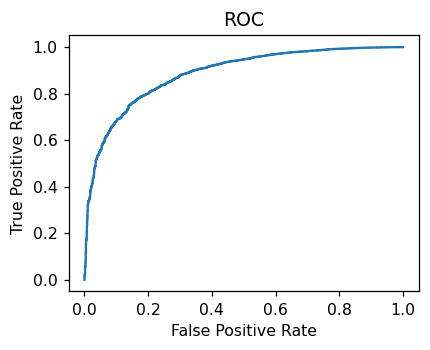

In [ ]:
# ROC Curve

preds = test_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure(figsize=(4, 3), dpi=113)
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

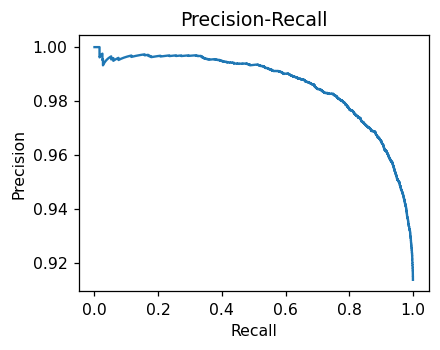

In [ ]:
# Precision-Recall Curve

preds = test_predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
points = CurveMetrics(preds).get_curve('pr')

plt.figure(figsize=(4, 3), dpi=113)
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(x_val, y_val)

# **5 Extra - Kaggle submission**
To submit my predictions to Kaggle, I need to apply all the transformations to the entire dataset `df`, load the unlabeled dataset `unlabeled`, apply all the transformations and make the predictions on its encounters.

In [ ]:
df_transformed = missing_transformer.transform(df)
df_transformed = df_transformed.drop(*to_drop)
over_sampled = oversampling(df_transformed, TARGET_VARIABLE)

In [ ]:
kaggle_rf_model_kaggle = selected_random_forest_pipeline(over_sampled, NEW_NUMERICAL, NEW_CATEGORICAL, TARGET_VARIABLE)

In [ ]:
unlabeled = spark.read.load(GDRIVE_UNLABELED_DATASET_FILE, 
                     format="csv", 
                     sep=",", 
                     inferSchema=True, 
                     header=True
                     )

for c in NUMERIC:
    unlabeled = unlabeled.withColumn(c, unlabeled[c].cast("float"))
for c in INTEGER:
    unlabeled = unlabeled.withColumn(c, unlabeled[c].cast("int"))

cols = [F.when(~F.col(x).isin("NA"), F.col(x)).alias(x)  for x in unlabeled.columns]
unlabeled = unlabeled.select(*cols)

In [ ]:
unlabeled_transformed = missing_transformer.transform(unlabeled)
unlabeled_transformed = unlabeled_transformed.drop(*to_drop)

In [ ]:
kaggle_predictions = kaggle_rf_model_kaggle.transform(unlabeled_transformed)

In [ ]:
kaggle_submission = kaggle_predictions.select("encounter_id", "probability")

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

prob_of_surviving=udf(lambda v:float(v[1]),FloatType())

In [ ]:
kaggle_submission = kaggle_submission.withColumn('hospital_death', prob_of_surviving('probability')).drop('probability')

In [ ]:
kaggle_submission.toPandas().to_csv('/content/gdrive/My Drive/bd_project/datasets/kaggle_submission.csv', index=False)